In [38]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import random
np.random.seed(1)
random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_file = 'experiments/model_experiments_configs_max70steps_8ksim.json'

In [3]:
def json_results_to_dataframe(json_data):
    experiments = []
    metadata = json_data['metadata']

    # Count undone experiments and partial results
    undone_by_help = {}
    results_count = {1: 0, 2: 0, 3: 0}  # Count of experiments with at least 1,2,3 results

    for exp in json_data['experiments']:
        # Count undone experiments
        if exp['total_reward'] is None:
            help_id = exp['help_id']
            undone_by_help[help_id] = undone_by_help.get(help_id, 0) + 1
            continue

        # Count experiments with different numbers of results
        num_results = len(exp['total_reward'])
        for threshold in [1, 2, 3]:
            if num_results >= threshold:
                results_count[threshold] += 1

        # Process results for dataframe
        for run_idx in range(num_results):
            exp_data = {
                'experiment_id': exp['experiment_id'],
                'state_id': exp['state_id'],
                'help_id': exp['help_id'],
                'initial_positions': str(exp['initial_positions']),
                'total_reward': exp['total_reward'][run_idx],
                'total_discounted_reward': exp['total_discounted_reward'][run_idx],
                'episode_length': exp['task_progress']['episode_length'][run_idx],
                'red_cup_full': exp['task_progress']['red_cup_full'][run_idx],
                'blue_cup_full': exp['task_progress']['blue_cup_full'][run_idx],
                'red_cup_in_position': exp['task_progress']['red_cup_in_position'][run_idx],
                'blue_cup_in_position': exp['task_progress']['blue_cup_in_position'][run_idx],
                'can_in_trash': exp['task_progress']['can_in_trash'][run_idx],
                'terminated': exp['task_progress']['terminated'][run_idx],
                'run_time': exp['run_time'][run_idx],
                'obstacles_to_exclude': str(exp['obstacles_to_exclude']),
                'run_id': run_idx
            }
            experiments.append(exp_data)

    # Print statistics
    print("\nUndone experiments by help action:")
    for help_id in sorted(undone_by_help.keys()):
        print(f"Help action {help_id}: {undone_by_help[help_id]} undone experiments")

    print("\nExperiments with at least X results:")
    for num_results in sorted(results_count.keys()):
        print(f"At least {num_results} results: {results_count[num_results]} experiments")

    return pd.DataFrame(experiments), metadata


In [4]:
with open(results_file) as f:
    json_data = json.load(f)

df, metadata = json_results_to_dataframe(json_data)



Undone experiments by help action:

Experiments with at least X results:
At least 1 results: 600 experiments
At least 2 results: 600 experiments
At least 3 results: 600 experiments


In [5]:
df

,experiment_id,state_id,help_id,initial_positions,total_reward,total_discounted_reward,episode_length,red_cup_full,blue_cup_full,red_cup_in_position,blue_cup_in_position,can_in_trash,terminated,run_time,obstacles_to_exclude,run_id
0,0,0,-1,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",16.1,8.943025,34,True,True,True,True,True,True,184.708639,[],0
1,0,0,-1,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",16.1,8.943025,34,True,True,True,True,True,True,195.656615,[],1
2,0,0,-1,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",15.1,7.981169,36,True,True,True,True,True,True,211.498851,[],2
3,1,0,0,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",16.1,8.324272,34,True,True,True,True,True,True,186.396618,[1],0
4,1,0,0,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",15.1,7.193695,36,True,True,True,True,True,True,205.308625,[1],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,598,119,2,"{'top_shelf_left': None, 'top_shelf_right': No...",-35.0,-18.921935,70,False,False,False,False,False,False,13951.865321,[3],1
1796,598,119,2,"{'top_shelf_left': None, 'top_shelf_right': No...",-35.0,-18.921935,70,False,False,False,False,False,False,13954.443138,[3],2
1797,599,119,3,"{'top_shelf_left': None, 'top_shelf_right': No...",-35.0,-18.921935,70,False,False,False,False,False,False,13928.285255,[4],0
1798,599,119,3,"{'top_shelf_left': None, 'top_shelf_right': No...",-35.0,-18.921935,70,False,False,False,False,False,False,13947.266298,[4],1


# Basic Statistics


In [6]:
# Calculate mean and std of rewards per experiment (state-help pair)
experiment_stats = df.groupby(['state_id', 'help_id']).agg({
    'total_reward': ['mean', 'std'],
    'total_discounted_reward': ['mean', 'std'],
    'episode_length': ['mean', 'std']
}).reset_index()

print("Overall Statistics:")
print("\nReward Statistics:")
print(df['total_reward'].describe())
print("\nDiscounted Reward Statistics:")
print(df['total_discounted_reward'].describe())
print("\nEpisode Length Statistics:")
print(df['episode_length'].describe())


Overall Statistics:

Reward Statistics:
count    1800.000000
mean       -3.065500
std        18.241789
min       -35.000000
25%       -23.000000
50%         4.100000
75%        14.100000
max        20.600000
Name: total_reward, dtype: float64

Discounted Reward Statistics:
count    1800.000000
mean       -1.606773
std         9.335768
min       -18.921935
25%       -10.054693
50%         1.899753
75%         6.277608
max        14.054843
Name: total_discounted_reward, dtype: float64

Episode Length Statistics:
count    1800.000000
mean       40.942778
std        20.503272
min         2.000000
25%        24.000000
50%        34.000000
75%        70.000000
max        70.000000
Name: episode_length, dtype: float64


In [7]:
# Success Rates Analysis

def calculate_success_rates(df):
    # Full success: both cups full and can in trash
    df['full_success'] = (df['red_cup_full'] & df['blue_cup_full'] & df['can_in_trash'])

    # Partial success: at least one cup full and can in trash
    df['partial_success'] = ((df['red_cup_full'] | df['blue_cup_full']) & df['can_in_trash'])

    # Calculate rates by help_id
    success_rates = df.groupby('help_id').agg({
        'full_success': 'mean',
        'partial_success': 'mean',
        'terminated': 'mean',
        'red_cup_full': 'mean',
        'blue_cup_full': 'mean',
        'red_cup_in_position': 'mean',
        'blue_cup_in_position': 'mean',
        'can_in_trash': 'mean'
    }).round(3)

    return success_rates


success_rates = calculate_success_rates(df)
print("\nSuccess Rates by Help Action:")
print(success_rates)



Success Rates by Help Action:
         full_success  partial_success  terminated  red_cup_full  \
help_id                                                            
-1              0.033            0.294       0.467         0.169   
 0              0.822            0.967       0.969         0.967   
 1              0.725            0.928       0.928         0.883   
 2              0.042            0.339       0.492         0.194   
 3              0.042            0.336       0.494         0.192   

         blue_cup_full  red_cup_in_position  blue_cup_in_position  \
help_id                                                             
-1               0.158                0.458                 0.456   
 0               0.822                0.983                 0.833   
 1               0.769                0.925                 0.817   
 2               0.186                0.433                 0.492   
 3               0.186                0.447                 0.486   

        


Episode Length Statistics for Full Success:
count    599.000000
mean      35.460768
std        4.506559
min       25.000000
25%       32.000000
50%       35.000000
75%       38.000000
max       57.000000
Name: episode_length, dtype: float64

Episode Length Statistics for Partial Success (excluding full success):
count    432.000000
mean      24.465278
std        5.950195
min       16.000000
25%       21.000000
50%       24.000000
75%       26.000000
max       59.000000
Name: episode_length, dtype: float64

Episode Length Statistics for Failed Episodes:
count    769.000000
mean      54.469441
std       24.283201
min        2.000000
25%       23.000000
50%       70.000000
75%       70.000000
max       70.000000
Name: episode_length, dtype: float64


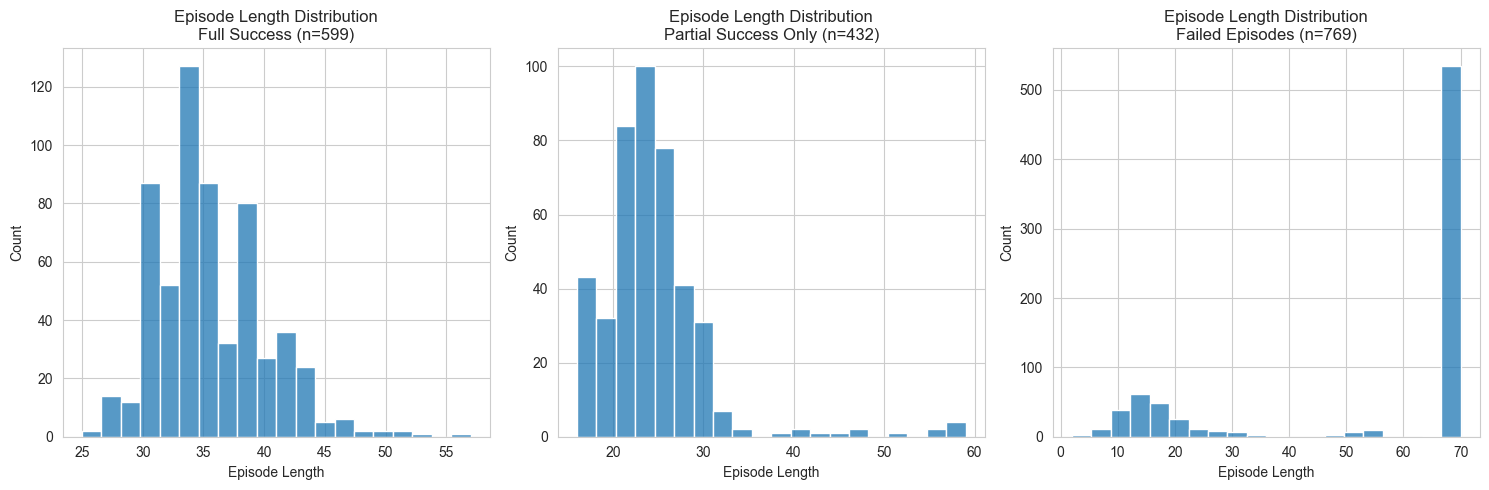


Episode Length Statistics by Help Action and Success Type:
                                      count       mean        std   min   25%  \
help_id full_success partial_success                                            
-1      False        False            254.0  53.724409  24.422233   2.0  21.5   
                     True              94.0  26.308511   6.814006  17.0  23.0   
        True         True              12.0  33.750000   1.484771  30.0  33.0   
 0      False        False             12.0  32.500000  27.671778   6.0   9.0   
                     True              52.0  21.115385   7.729886  16.0  18.0   
        True         True             296.0  35.790541   4.386039  28.0  33.0   
 1      False        False             26.0  25.230769  18.306955   3.0  14.0   
                     True              73.0  22.013699   5.672774  16.0  20.0   
        True         True             261.0  35.249042   4.831313  25.0  32.0   
 2      False        False            238.0  57.4

In [8]:
# Episode Length Distribution Analysis by Success Type
plt.figure(figsize=(15, 5))

# Full success episodes
plt.subplot(131)
successful_episodes = df[df['full_success']]
if len(successful_episodes) > 0:
    sns.histplot(data=successful_episodes, x='episode_length', bins=20)
    plt.title(f'Episode Length Distribution\nFull Success (n={len(successful_episodes)})')
    plt.xlabel('Episode Length')
    print("\nEpisode Length Statistics for Full Success:")
    print(successful_episodes['episode_length'].describe())
else:
    plt.text(0.5, 0.5, 'No fully successful episodes', ha='center')
    plt.title('Full Success Episodes')

# Partial success episodes (but not full success)
plt.subplot(132)
partial_episodes = df[df['partial_success'] & ~df['full_success']]
if len(partial_episodes) > 0:
    sns.histplot(data=partial_episodes, x='episode_length', bins=20)
    plt.title(f'Episode Length Distribution\nPartial Success Only (n={len(partial_episodes)})')
    plt.xlabel('Episode Length')
    print("\nEpisode Length Statistics for Partial Success (excluding full success):")
    print(partial_episodes['episode_length'].describe())
else:
    plt.text(0.5, 0.5, 'No partially successful episodes', ha='center')
    plt.title('Partial Success Episodes')

# Failed episodes
plt.subplot(133)
failed_episodes = df[~df['partial_success']]
if len(failed_episodes) > 0:
    sns.histplot(data=failed_episodes, x='episode_length', bins=20)
    plt.title(f'Episode Length Distribution\nFailed Episodes (n={len(failed_episodes)})')
    plt.xlabel('Episode Length')
    print("\nEpisode Length Statistics for Failed Episodes:")
    print(failed_episodes['episode_length'].describe())
else:
    plt.text(0.5, 0.5, 'No failed episodes', ha='center')
    plt.title('Failed Episodes')

plt.tight_layout()
plt.show()

# Additional breakdown by help action
success_episode_lengths = df.groupby(['help_id', 'full_success', 'partial_success'])['episode_length'].describe()
print("\nEpisode Length Statistics by Help Action and Success Type:")
print(success_episode_lengths)

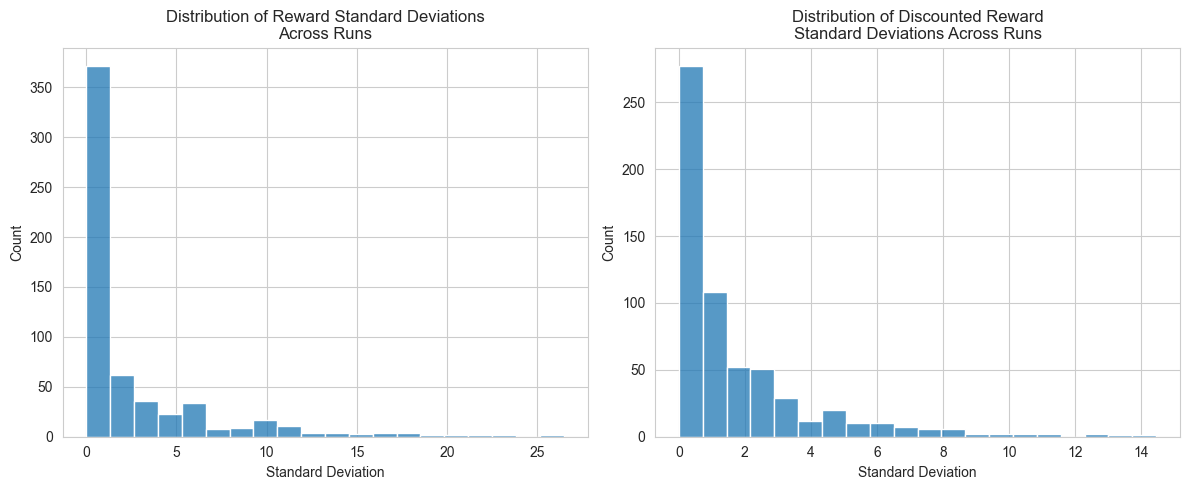

In [9]:
# Calculate variance between runs for each state-help pair
stability_analysis = df.groupby(['state_id', 'help_id']).agg({
    'total_reward': ['mean', 'std', 'count'],
    'total_discounted_reward': ['mean', 'std', 'count']
}).reset_index()

# Plot distribution of standard deviations
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.histplot(stability_analysis[('total_reward', 'std')].dropna(), bins=20)
plt.title('Distribution of Reward Standard Deviations\nAcross Runs')
plt.xlabel('Standard Deviation')

plt.subplot(122)
sns.histplot(stability_analysis[('total_discounted_reward', 'std')].dropna(), bins=20)
plt.title('Distribution of Discounted Reward\nStandard Deviations Across Runs')
plt.xlabel('Standard Deviation')

plt.tight_layout()
plt.show()


# Value of Assistance Analysis

In [10]:
def compute_value_differences(df):
    baseline_means = df[df['help_id'] == -1].groupby('state_id').agg({
        'total_discounted_reward': 'mean',
        'run_time': 'sum'  # Sum the run times for baseline runs
    }).reset_index()

    value_diff_results = []
    for _, baseline_row in baseline_means.iterrows():
        state_id = baseline_row['state_id']
        baseline_reward = baseline_row['total_discounted_reward']
        baseline_time = baseline_row['run_time']

        # Get mean rewards and sum of run times for help experiments
        help_exps = df[
            (df['state_id'] == state_id) &
            (df['help_id'] != -1)
        ].groupby(['state_id', 'help_id']).agg({
            'total_discounted_reward': 'mean',
            'run_time': 'sum',  # Sum the run times for helped runs
            'initial_positions': 'first',
            'obstacles_to_exclude': 'first'
        }).reset_index()

        for _, help_row in help_exps.iterrows():
            value_diff_results.append({
                'state_id': state_id,
                'help_id': help_row['help_id'],
                'value_diff': help_row['total_discounted_reward'] - baseline_reward,
                'baseline_value': baseline_reward,
                'computation_time': baseline_time + help_row['run_time'],  # Total time for both runs
                'initial_positions': help_row['initial_positions'],
                'obstacles_to_exclude': help_row['obstacles_to_exclude']
            })

    return pd.DataFrame(value_diff_results)


def compute_voa(vd_df):
    # Compute VOA for each help action (average value difference across states)
    voa_results = []

    for help_id, group in vd_df.groupby('help_id'):
        empirical_voa = group['value_diff'].mean()
        empirical_variance = group['value_diff'].var()

        voa_results.append({
            'help_id': help_id,
            'empirical_voa': empirical_voa,
            'empirical_voa_variance': empirical_variance,
            'n_states': len(group)
        })

    return pd.DataFrame(voa_results)

Compute value differences and VOA:

In [11]:

vd_df = compute_value_differences(df)
vd_df

,state_id,help_id,value_diff,baseline_value,computation_time,initial_positions,obstacles_to_exclude
0,0.0,0,-1.817240,8.622406,1234.222095,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",[1]
1,0.0,1,-1.515116,8.622406,1083.819640,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",[2]
2,0.0,2,-7.431251,8.622406,1458.071283,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",[3]
3,0.0,3,-1.333140,8.622406,1175.685010,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",[4]
4,1.0,0,0.346844,8.381485,1234.984570,"{'top_shelf_left': 'red_cup', 'top_shelf_right...",[1]
...,...,...,...,...,...,...,...
475,118.0,3,0.000000,-18.921935,82374.646866,"{'top_shelf_left': None, 'top_shelf_right': No...",[4]
476,119.0,0,20.593395,-13.415284,81681.517529,"{'top_shelf_left': None, 'top_shelf_right': No...",[1]
477,119.0,1,15.184342,-13.415284,82110.686085,"{'top_shelf_left': None, 'top_shelf_right': No...",[2]
478,119.0,2,-5.506652,-13.415284,82870.058141,"{'top_shelf_left': None, 'top_shelf_right': No...",[3]


In [12]:
voa_df = compute_voa(vd_df)
voa_df

,help_id,empirical_voa,empirical_voa_variance,n_states
0,0,13.683558,52.680520,120
1,1,13.456079,50.302321,120
2,2,0.060145,11.462741,120
3,3,0.132004,9.815189,120


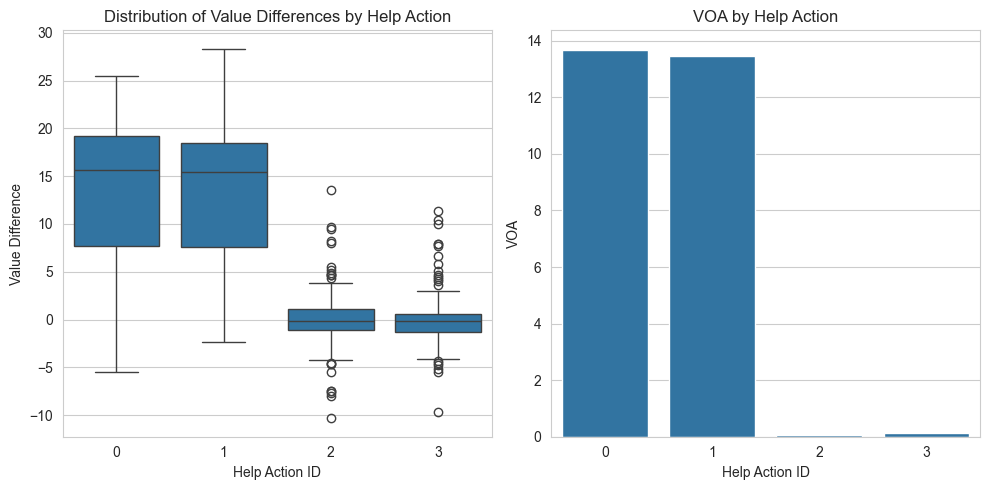

In [13]:
# Plot VOA distribution
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.boxplot(data=vd_df, x='help_id', y='value_diff')
plt.title('Distribution of Value Differences by Help Action')
plt.xlabel('Help Action ID')
plt.ylabel('Value Difference')

plt.subplot(122)
sns.barplot(data=voa_df, x='help_id', y='empirical_voa')
plt.title('VOA by Help Action')
plt.xlabel('Help Action ID')
plt.ylabel('VOA')

plt.tight_layout()
plt.show()


In [14]:
# Bootstrap Confidence Intervals for VOA

def bootstrap_voa_confidence_intervals(vd_df, n_bootstrap=1000):
    results = []
    ci_levels = {'95': [2.5, 97.5], '90': [5, 95], '80': [10, 90]}

    for help_id, group in vd_df.groupby('help_id'):
        boots = [group['value_diff'].sample(n=len(group), replace=True).mean()
                 for _ in range(n_bootstrap)]
        mean_voa = group['value_diff'].mean()

        # Calculate CIs for each confidence level
        cis = {}
        for conf_level, percs in ci_levels.items():
            ci_low, ci_high = np.percentile(boots, percs)
            cis[conf_level] = (ci_low, ci_high)

        results.append({
            'help_id': help_id,
            'voa': mean_voa,
            **{f'ci_{k}_low': v[0] for k, v in cis.items()},
            **{f'ci_{k}_high': v[1] for k, v in cis.items()}
        })

    return pd.DataFrame(results)


 Calculate bootstrap confidence intervals

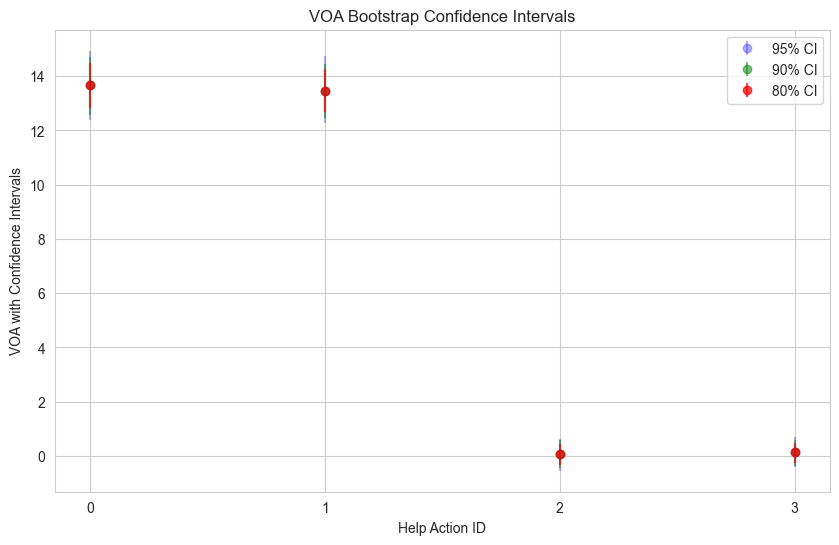


Bootstrap Results:
   help_id        voa  ci_95_low  ci_90_low  ci_80_low  ci_95_high  \
0        0  13.683558  12.370875  12.580325  12.816959   14.940423   
1        1  13.456079  12.268407  12.456027  12.688092   14.748012   
2        2   0.060145  -0.545357  -0.445799  -0.340409    0.637499   
3        3   0.132004  -0.424882  -0.355305  -0.263415    0.683187   

   ci_90_high  ci_80_high  
0   14.726965   14.478006  
1   14.451748   14.274229  
2    0.571185    0.456369  
3    0.594713    0.477029  


In [15]:
bootstrap_results = bootstrap_voa_confidence_intervals(vd_df)

# Merge the bootstrap results with voa_df
voa_df = voa_df.merge(
    bootstrap_results[[
        'help_id',
        'ci_95_low', 'ci_95_high',
        'ci_90_low', 'ci_90_high',
        'ci_80_low', 'ci_80_high'
    ]],
    on='help_id'
)

# Plot VOA with confidence intervals
plt.figure(figsize=(10, 6))
x = range(len(bootstrap_results))

plt.errorbar(x, bootstrap_results['voa'],
             yerr=[bootstrap_results['voa'] - bootstrap_results['ci_95_low'],
                   bootstrap_results['ci_95_high'] - bootstrap_results['voa']],
             fmt='o', alpha=0.3, color='blue', label='95% CI')
plt.errorbar(x, bootstrap_results['voa'],
             yerr=[bootstrap_results['voa'] - bootstrap_results['ci_90_low'],
                   bootstrap_results['ci_90_high'] - bootstrap_results['voa']],
             fmt='o', alpha=0.5, color='green', label='90% CI')
plt.errorbar(x, bootstrap_results['voa'],
             yerr=[bootstrap_results['voa'] - bootstrap_results['ci_80_low'],
                   bootstrap_results['ci_80_high'] - bootstrap_results['voa']],
             fmt='o', alpha=0.7, color='red', label='80% CI')

plt.xticks(x, bootstrap_results['help_id'])
plt.xlabel('Help Action ID')
plt.ylabel('VOA with Confidence Intervals')
plt.title('VOA Bootstrap Confidence Intervals')
plt.legend()
plt.show()

print("\nBootstrap Results:")
print(bootstrap_results)

# Heuristics evaluation

In [16]:
from lab_po_manipulation.heuristics import h_vd_results, h_first_step_planning_value_diff, h_rollout_policy_value, h_full_info_planning_value_diff

from lab_po_manipulation.heuristics_evaluation import test_heuristic_on_problem, heuristic_metrics

def save_test_results(results, path):
    results.to_csv(path)

def load_test_results(path):
    results = pd.read_csv(path)
    return results

all_metrics = {}

# Baseline Episode Simulation

In [39]:
n_states = [1, 5, 25, 50, 100]

for n in n_states:
    res = test_heuristic_on_problem(voa_df, heuristic_function=h_vd_results, heuristic_kwargs={'n_states': n, 'vd_table': vd_df})
    print(f"\nResults for {n} states:")
    metrics = heuristic_metrics(res)
    all_metrics[f'baseline_mc_{n}_states'] = metrics

for n in n_states:
    metrics = all_metrics[f'baseline_mc_{n}_states']
    print("--------------------")
    print(f"n_states: {n}")
    print(metrics)
    print("--------------------")


Loaded roadmap with 442 vertices and 1724 edges
Loaded roadmap with 162 vertices and 448 edges

Results for 1 states:
Loaded roadmap with 442 vertices and 1724 edges
Loaded roadmap with 162 vertices and 448 edges

Results for 5 states:
Loaded roadmap with 442 vertices and 1724 edges
Loaded roadmap with 162 vertices and 448 edges

Results for 25 states:
Loaded roadmap with 442 vertices and 1724 edges
Loaded roadmap with 162 vertices and 448 edges

Results for 50 states:
Loaded roadmap with 442 vertices and 1724 edges
Loaded roadmap with 162 vertices and 448 edges

Results for 100 states:
--------------------
n_states: 1
{'top_1_accuracy': 0.0, 'top_2_accuracy': 1.0, 'spearman_correlation': 0.7999999999999999, 'spearman_correlation_pvalue': 0.20000000000000007, 'ci_weighted_correlation': 0.9030259054742634, 'rank_of_best_heuristic': 2, 'voa_of_best_heuristic': 13.456079460426857, 'partial_ordering_agreement': 1.0, 'partial_ordering_strict_pairs_ratio': 0.6666666666666666, 'partial_orderi

# First Step Planning Heuristic

In [18]:
# uncomment to recalulate

# heuristic_kwargs = {'n_trials': 1}
# res = test_heuristic_on_problem(voa_df, heuristic_function=h_first_step_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
# save_test_results(res, 'heuristics_evaluation/first_step_planning_1_trials.csv')
#
# heuristic_kwargs = {'n_trials': 5}
# res = test_heuristic_on_problem(voa_df, heuristic_function=h_first_step_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
# save_test_results(res, 'heuristics_evaluation/first_step_planning_5_trials.csv')
#
# heuristic_kwargs = {'n_trials': 10}
# res = test_heuristic_on_problem(voa_df, heuristic_function=h_first_step_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
# save_test_results(res, 'heuristics_evaluation/first_step_planning_10_trials.csv')


In [19]:
res_plain_first_step_planning = load_test_results('heuristics_evaluation/first_step_planning_1_trials.csv')
metrics = heuristic_metrics(res_plain_first_step_planning)
all_metrics['plain_first_step_planning'] = metrics
metrics

{'top_1_accuracy': 1.0,
 'top_2_accuracy': 0.5,
 'spearman_correlation': 0.19999999999999998,
 'spearman_correlation_pvalue': 0.8,
 'ci_weighted_correlation': -0.5070372803967108,
 'rank_of_best_heuristic': 1,
 'voa_of_best_heuristic': 13.68355822857981,
 'partial_ordering_agreement': 0.5,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4,
 'partial_ordering_n_total_pairs': 6,
 'mean_computation_time': 4.709881901741028,
 'std_computation_time': 0.11984676978112878,
 'max_computation_time': 4.790055990219116,
 'min_computation_time': 4.531518459320068}

In [20]:
res_first_step_planning_5 = load_test_results('heuristics_evaluation/first_step_planning_5_trials.csv')
metrics = heuristic_metrics(res_first_step_planning_5)
all_metrics['first_step_planning_5_trials'] = metrics
metrics

{'top_1_accuracy': 1.0,
 'top_2_accuracy': 0.5,
 'spearman_correlation': 0.19999999999999998,
 'spearman_correlation_pvalue': 0.8,
 'ci_weighted_correlation': -0.41241114008831986,
 'rank_of_best_heuristic': 1,
 'voa_of_best_heuristic': 13.68355822857981,
 'partial_ordering_agreement': 0.5,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4,
 'partial_ordering_n_total_pairs': 6,
 'mean_computation_time': 22.767107486724854,
 'std_computation_time': 0.629422162436269,
 'max_computation_time': 23.45959162712097,
 'min_computation_time': 21.99183225631714}

In [21]:
res_first_step_planning_10 = load_test_results('heuristics_evaluation/first_step_planning_10_trials.csv')
metrics = heuristic_metrics(res_first_step_planning_10)
all_metrics['first_step_planning_10_trials'] = metrics
metrics

{'top_1_accuracy': 1.0,
 'top_2_accuracy': 0.5,
 'spearman_correlation': 0.39999999999999997,
 'spearman_correlation_pvalue': 0.6,
 'ci_weighted_correlation': -0.4371107966795488,
 'rank_of_best_heuristic': 1,
 'voa_of_best_heuristic': 13.68355822857981,
 'partial_ordering_agreement': 0.5,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4,
 'partial_ordering_n_total_pairs': 6,
 'mean_computation_time': 45.396030485630035,
 'std_computation_time': 0.8551220558680572,
 'max_computation_time': 46.09555578231812,
 'min_computation_time': 44.1777720451355}

# Rollout Policy Heuristic

==VOA was zero for all rollouts==

In [22]:
# uncomment to recalulate
# That will always return VOA of 0, no need for that...

# heuristic_kwargs = {'n_rollouts': 1000}
# res = test_heuristic_on_problem(voa_df, heuristic_function=h_rollout_policy_value, heuristic_kwargs=heuristic_kwargs)
# save_test_results(res, 'heuristics_evaluation/rollout_policy_1_rollouts.csv')


# Full information planning heuristic

In [23]:
# uncomment to recalulate

import os
from pathlib import Path

k = 10 # number of runs

# For experiment with 1 state:
# exp_dir = 'heuristics_evaluation/full_info_planning_1_states'
# Path(exp_dir).mkdir(parents=True, exist_ok=True)
# # make sure dir is empty
# for file in os.listdir(exp_dir):
#     os.remove(os.path.join(exp_dir, file))
# heuristic_kwargs = {'n_states': 1}
# for i in range(k):
#     res = test_heuristic_on_problem(voa_df, heuristic_function=h_full_info_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
#     res.to_csv(f'{exp_dir}/run_{i}.csv')

# For experiments with 10, 50, 100 states:
# exp_dir = 'heuristics_evaluation/full_info_planning_10_states'
# Path(exp_dir).mkdir(parents=True, exist_ok=True)
# # make sure dir is empty
# for file in os.listdir(exp_dir):
#     os.remove(os.path.join(exp_dir, file))
# heuristic_kwargs = {'n_states': 10}
# for i in range(k):
#     res = test_heuristic_on_problem(voa_df, heuristic_function=h_full_info_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
#     res.to_csv(f'{exp_dir}/run_{i}.csv')
#
#
# exp_dir = 'heuristics_evaluation/full_info_planning_50_states'
# Path(exp_dir).mkdir(parents=True, exist_ok=True)
# # make sure dir is empty
# for file in os.listdir(exp_dir):
#     os.remove(os.path.join(exp_dir, file))
# heuristic_kwargs = {'n_states': 50}
# for i in range(k):
#     res = test_heuristic_on_problem(voa_df, heuristic_function=h_full_info_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
#     res.to_csv(f'{exp_dir}/run_{i}.csv')

# exp_dir = 'heuristics_evaluation/full_info_planning_100_states'
# Path(exp_dir).mkdir(parents=True, exist_ok=True)
# # make sure dir is empty
# for file in os.listdir(exp_dir):
#     os.remove(os.path.join(exp_dir, file))
# heuristic_kwargs = {'n_states': 100}
# for i in range(k):
#     res = test_heuristic_on_problem(voa_df, heuristic_function=h_full_info_planning_value_diff, heuristic_kwargs=heuristic_kwargs)
#     res.to_csv(f'{exp_dir}/run_{i}.csv')


In [35]:
metrics_list = []
exp_dir = 'heuristics_evaluation/full_info_planning_1_states'
for file in os.listdir(exp_dir):
    if file.endswith('.csv'):
        res = pd.read_csv(f'{exp_dir}/{file}', index_col=0)
        metrics = heuristic_metrics(res)
        metrics_list.append(metrics)

# Average metrics
avg_metrics = {key: sum(m[key] for m in metrics_list)/len(metrics_list)
              for key in metrics_list[0].keys()}

all_metrics['full_info_planning_1_states'] = avg_metrics
avg_metrics

{'top_1_accuracy': 0.0,
 'top_2_accuracy': 1.0,
 'spearman_correlation': 0.6666666666666666,
 'spearman_correlation_pvalue': 0.3333333333333333,
 'ci_weighted_correlation': 0.9994296075572463,
 'rank_of_best_heuristic': 2.0,
 'voa_of_best_heuristic': 13.456079460426857,
 'partial_ordering_agreement': 1.0,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4.0,
 'partial_ordering_n_total_pairs': 6.0,
 'mean_computation_time': 0.002159416675567585,
 'std_computation_time': 0.002252439952007083,
 'max_computation_time': 0.0051063696543375,
 'min_computation_time': 0.00021592775980630675}

In [25]:
metrics_list = []
exp_dir = 'heuristics_evaluation/full_info_planning_10_states'
for file in os.listdir(exp_dir):
    if file.endswith('.csv'):
        res = pd.read_csv(f'{exp_dir}/{file}', index_col=0)
        metrics = heuristic_metrics(res)
        metrics_list.append(metrics)

# Average metrics
avg_metrics = {key: sum(m[key] for m in metrics_list)/len(metrics_list)
              for key in metrics_list[0].keys()}
all_metrics['full_info_planning_10_states'] = avg_metrics
avg_metrics

{'top_1_accuracy': 0.0,
 'top_2_accuracy': 1.0,
 'spearman_correlation': 0.7999999999999999,
 'spearman_correlation_pvalue': 0.20000000000000007,
 'ci_weighted_correlation': 0.9976374095715785,
 'rank_of_best_heuristic': 2.0,
 'voa_of_best_heuristic': 13.456079460426857,
 'partial_ordering_agreement': 1.0,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4.0,
 'partial_ordering_n_total_pairs': 6.0,
 'mean_computation_time': 0.0209964315096537,
 'std_computation_time': 0.017051585634430055,
 'max_computation_time': 0.04224260648091633,
 'min_computation_time': 0.006706953048705999}

In [26]:
metrics_list = []
exp_dir = 'heuristics_evaluation/full_info_planning_50_states'
for file in os.listdir(exp_dir):
    if file.endswith('.csv'):
        res = pd.read_csv(f'{exp_dir}/{file}', index_col=0)
        metrics = heuristic_metrics(res)
        metrics_list.append(metrics)

# Average metrics
avg_metrics = {key: sum(m[key] for m in metrics_list)/len(metrics_list)
              for key in metrics_list[0].keys()}
all_metrics['full_info_planning_50_states'] = avg_metrics
avg_metrics

{'top_1_accuracy': 0.6666666666666666,
 'top_2_accuracy': 1.0,
 'spearman_correlation': 0.8666666666666666,
 'spearman_correlation_pvalue': 0.1333333333333334,
 'ci_weighted_correlation': 0.9997823879673587,
 'rank_of_best_heuristic': 1.3333333333333333,
 'voa_of_best_heuristic': 13.607731972528827,
 'partial_ordering_agreement': 1.0,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666666,
 'partial_ordering_n_strict_pairs': 4.0,
 'partial_ordering_n_total_pairs': 6.0,
 'mean_computation_time': 0.10338505109151201,
 'std_computation_time': 0.07999062766429181,
 'max_computation_time': 0.20498736699422196,
 'min_computation_time': 0.03585696220397944}

In [27]:
metrics_list = []
exp_dir = 'heuristics_evaluation/full_info_planning_100_states'
for file in os.listdir(exp_dir):
    if file.endswith('.csv'):
        res = pd.read_csv(f'{exp_dir}/{file}', index_col=0)
        metrics = heuristic_metrics(res)
        metrics_list.append(metrics)

# Average metrics
avg_metrics = {key: sum(m[key] for m in metrics_list)/len(metrics_list)
              for key in metrics_list[0].keys()}
all_metrics['full_info_planning_100_states'] = avg_metrics
avg_metrics


{'top_1_accuracy': 0.7,
 'top_2_accuracy': 1.0,
 'spearman_correlation': 0.9199999999999999,
 'spearman_correlation_pvalue': 0.08000000000000003,
 'ci_weighted_correlation': 0.9998210347674437,
 'rank_of_best_heuristic': 1.3,
 'voa_of_best_heuristic': 13.615314598133924,
 'partial_ordering_agreement': 1.0,
 'partial_ordering_strict_pairs_ratio': 0.6666666666666667,
 'partial_ordering_n_strict_pairs': 4.0,
 'partial_ordering_n_total_pairs': 6.0,
 'mean_computation_time': 0.20890775918960572,
 'std_computation_time': 0.1602619623765574,
 'max_computation_time': 0.41252162456512453,
 'min_computation_time': 0.07631287574768063}

In [28]:
all_metrics.keys()

dict_keys(['baseline_mc_1_states', 'baseline_mc_5_states', 'baseline_mc_25_states', 'baseline_mc_50_states', 'baseline_mc_100_states', 'plain_first_step_planning', 'first_step_planning_5_trials', 'first_step_planning_10_trials', 'full_info_planning_1_states', 'full_info_planning_10_states', 'full_info_planning_50_states', 'full_info_planning_100_states'])

# plotting

In [29]:
from rocksample_experiments.heuristics_evaluation import create_grouped_bar_plot


In [30]:
plot_config = {
    'Baseline PE': {
        'display_name': 'Policy Evaluation Baseline[n_states(k)]',
        'bars': [
            {'name': '1', 'heuristic': 'baseline_mc_1_states'},
            {'name': '5', 'heuristic': 'baseline_mc_5_states'},
            {'name': '25', 'heuristic': 'baseline_mc_25_states'},
            {'name': '100', 'heuristic': 'baseline_mc_100_states'}
        ],
        'color_idx': 0
    },
    'First Step': {
        'display_name': 'First Action Value[n_repeats]',
        'bars': [
            {'name': '1', 'heuristic': 'plain_first_step_planning'},
            {'name': '5', 'heuristic': 'first_step_planning_5_trials'},
            {'name': '10', 'heuristic': 'first_step_planning_10_trials'}
        ],
        'color_idx': 1
    },
    'Full Info': {
        'display_name': 'Full Info Deterministic Planning[n_states]',
        'bars': [
            {'name': '1', 'heuristic': 'full_info_planning_1_states'},
            {'name': '10', 'heuristic': 'full_info_planning_10_states'},
            {'name': '50', 'heuristic': 'full_info_planning_50_states'},
            {'name': '100', 'heuristic': 'full_info_planning_100_states'}
        ],
        'color_idx': 4
    }
}

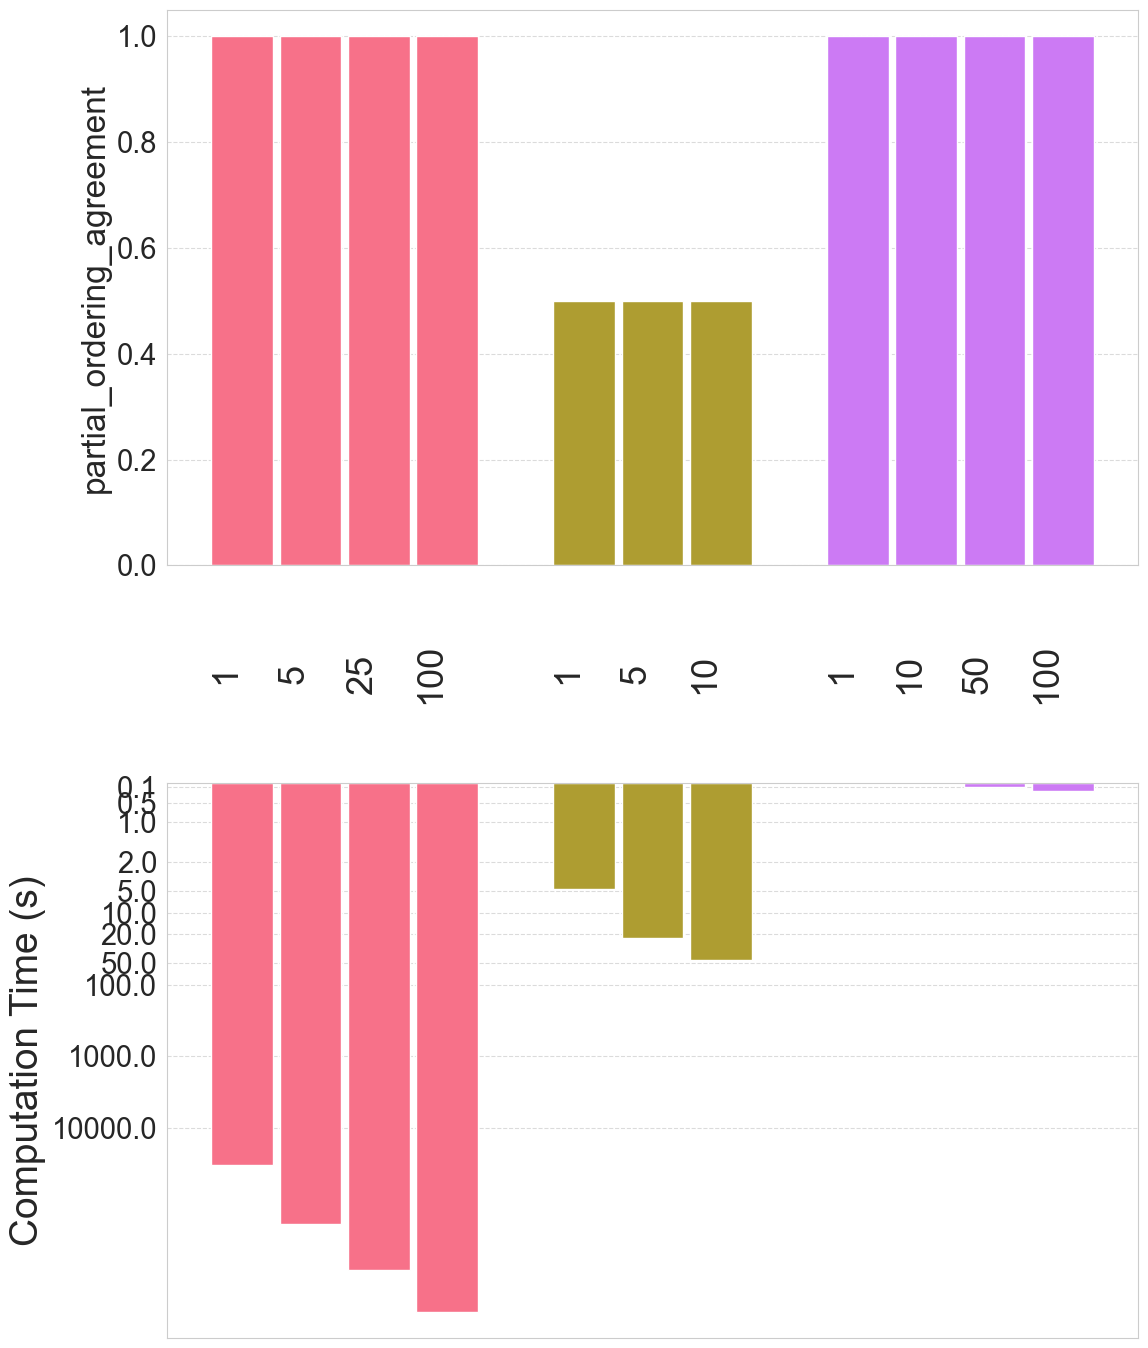

In [40]:
fig = create_grouped_bar_plot(all_metrics, 'partial_ordering_agreement', plot_config)

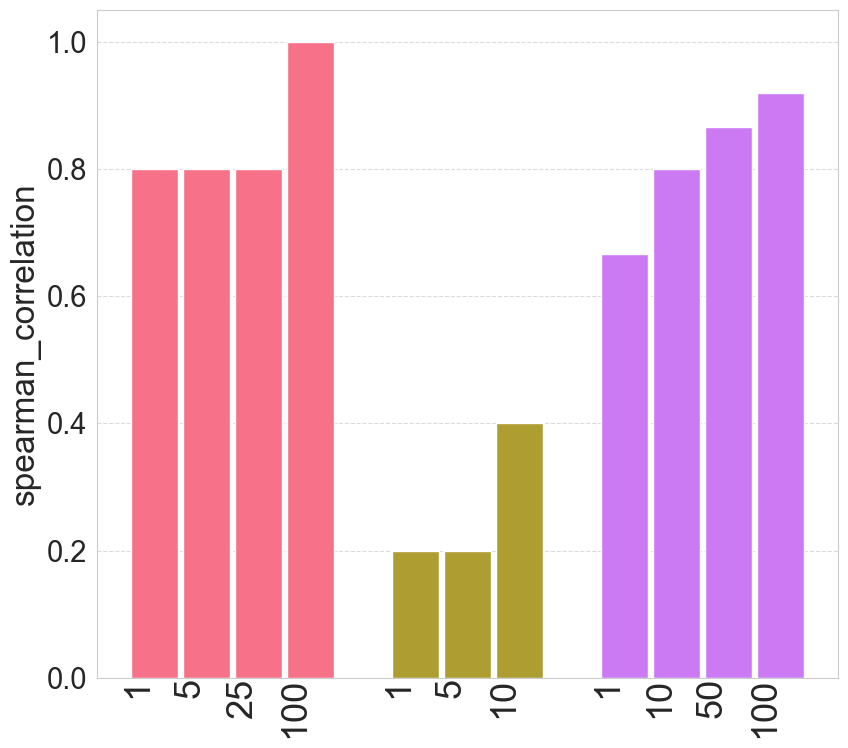

In [41]:
fig = create_grouped_bar_plot(all_metrics, 'spearman_correlation', plot_config, show_computation_time_mirror=False)

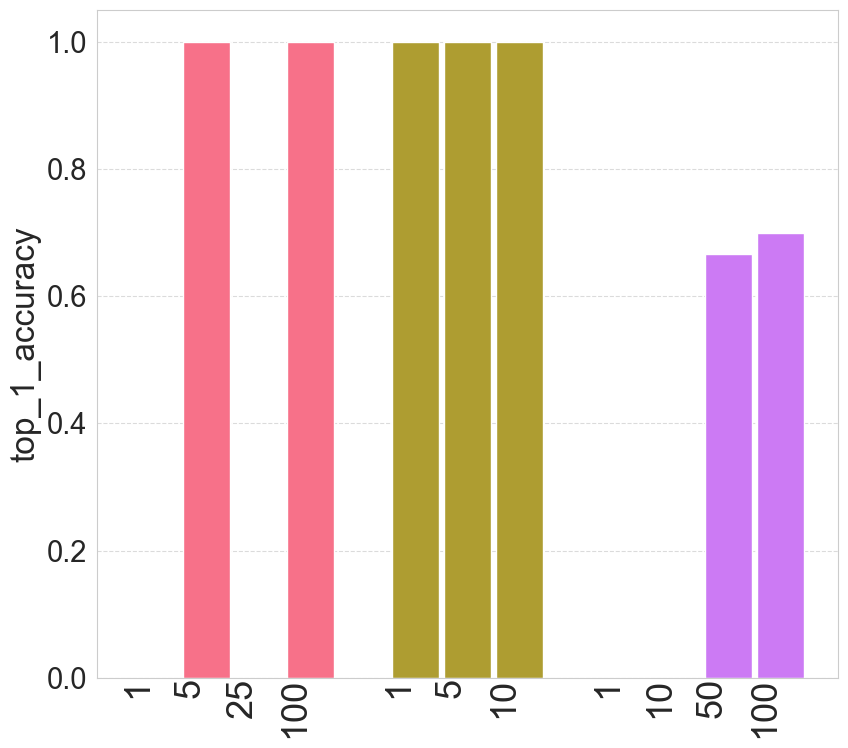

In [42]:
fig = create_grouped_bar_plot(all_metrics, 'top_1_accuracy', plot_config, show_computation_time_mirror=False)

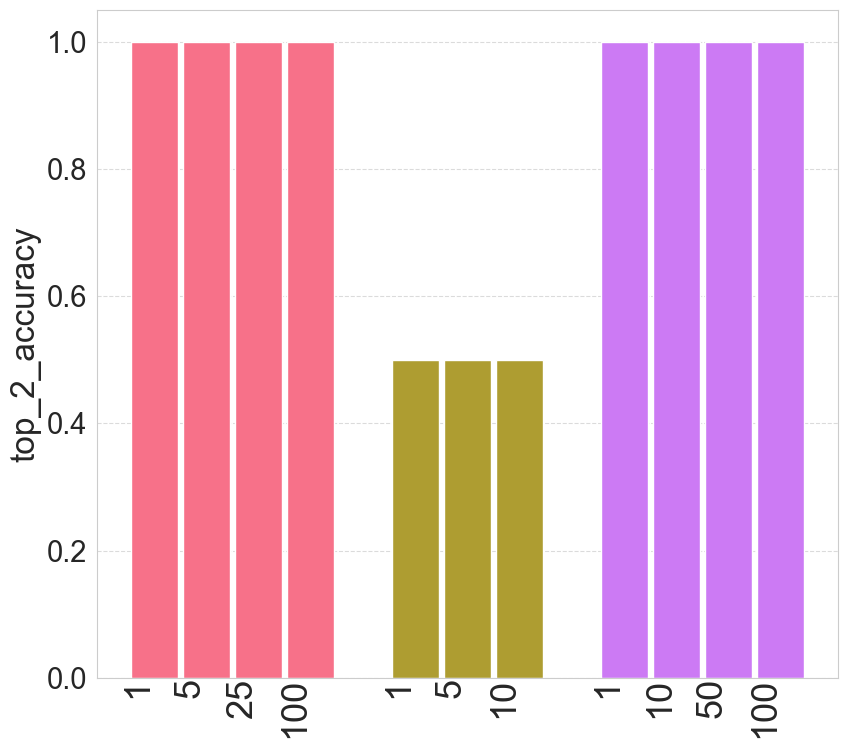

In [43]:
fig = create_grouped_bar_plot(all_metrics, 'top_2_accuracy', plot_config, show_computation_time_mirror=False)